In [1]:
# Import all the tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Models from sklearn
from sklearn.linear_model import LogisticRegression # see the map
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
df_train = pd.read_csv("data/TabularPlaygroundSeries-Oct2021/train.csv")
df_train.shape

(1000000, 287)

In [3]:
df_train

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
0,0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,...,0,1,0,0,0,0,0,0,0,1
1,1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,...,0,1,0,0,0,0,0,0,0,1
2,2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,...,0,0,0,1,1,0,0,0,0,1
3,3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,...,0,0,0,0,1,0,0,0,0,1
4,4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,...,0,1,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,0.204312,0.344754,0.262267,0.228333,0.610727,0.357463,0.490586,0.613655,0.509203,...,0,0,0,1,0,0,1,0,0,1
999996,999996,0.182004,0.564019,0.242564,0.241178,0.453623,0.469513,0.477518,0.659226,0.519219,...,0,0,0,0,0,0,0,0,1,0
999997,999997,0.250304,0.491553,0.098547,0.235656,0.771272,0.368018,0.531642,0.598111,0.618474,...,0,0,0,0,0,0,0,0,0,0
999998,999998,0.203572,0.534923,0.180118,0.213109,0.654544,0.535152,0.316271,0.652522,0.398026,...,0,0,0,0,0,0,0,0,0,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 287 entries, id to target
dtypes: float64(240), int64(47)
memory usage: 2.1 GB


In [5]:
df_train.isna().sum()

id        0
f0        0
f1        0
f2        0
f3        0
         ..
f281      0
f282      0
f283      0
f284      0
target    0
Length: 287, dtype: int64

In [6]:
x_train = df_train.drop("target", axis=1)
y_train = df_train["target"]
y_train

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: int64

# CatBoost

In [52]:
from catboost import CatBoostClassifier


model_catboost = CatBoostClassifier(iterations=100000, 
                           task_type="GPU",
                           #depth=6,
                           random_seed=42,
                           od_type='Iter',
                           #learning_rate=0.1,
                           od_wait=10,
                           devices='0:1')
model_catboost.fit(x_train,
          y_train,
          plot=True,
          verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [53]:
model_catboost.score(x_train, y_train)

0.771571

# Kneighbors

In [ ]:
# Let's tune KNN

train_scores = []
test_scores = []

# Create a list of different values for n_neighbours
neighbors = range(1,21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neughbors
for i in neighbors: # default = 5
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(x_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(x_train, y_train))
    

In [ ]:
train_scores

In [ ]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores,label="Test score")
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()
plt.xticks(np.arange(1, 21, 1))
print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

# logisticRegression

In [10]:
# Create a hyperparameter grid for logisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
               "solver": ["liblinear"]} #return log scale

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
          "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)
          }

In [ ]:
# Tune LogisticRegression

np.random.seed(42)

# Setup
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                               param_distributions=log_reg_grid,
                               cv=5,
                               n_iter=20,
                               verbose=True)

# Fit 
rs_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
rs_log_reg.best_params_

In [10]:
np.random.seed(42)
rs_log_reg = LogisticRegression(max_iter=20, n_jobs=-1, verbose=True)

rs_log_reg.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   50.9s finished


LogisticRegression(max_iter=20, n_jobs=-1, verbose=True)

In [11]:
rs_log_reg.score(x_train,y_train)

0.499515

# Test

In [54]:
df_test = pd.read_csv("data/TabularPlaygroundSeries-Oct2021/test.csv")

In [55]:
df_test

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284
0,1000000,0.178216,0.435617,0.010230,0.202074,0.390170,0.324221,0.221722,0.738894,0.582588,...,1,0,0,0,0,0,1,1,1,0
1,1000001,0.181250,0.476455,0.022413,0.283146,0.598020,0.349508,0.283467,0.721575,0.268990,...,0,0,0,0,0,0,0,0,0,0
2,1000002,0.159721,0.451202,0.259649,0.365274,0.594634,0.413502,0.249318,0.642339,0.411104,...,0,0,0,0,0,0,1,0,0,0
3,1000003,0.182424,0.520976,0.095344,0.327742,0.741830,0.358711,0.270077,0.601662,0.297742,...,0,0,0,0,0,1,1,0,0,0
4,1000004,0.229329,0.336513,0.023511,0.300913,0.668738,0.481586,0.545660,0.667849,0.546045,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1499995,0.185473,0.525338,0.014945,0.204029,0.498957,0.431933,0.470553,0.731268,0.452134,...,1,0,0,0,0,0,1,0,0,0
499996,1499996,0.183194,0.553266,0.008055,0.280651,0.636591,0.478092,0.450386,0.582647,0.517270,...,1,0,0,0,0,0,0,1,0,0
499997,1499997,0.184650,0.533643,0.011218,0.201262,0.720698,0.472888,0.427469,0.589259,0.243879,...,1,1,0,0,0,0,0,0,0,0
499998,1499998,0.227731,0.513247,0.178603,0.313778,0.665656,0.401365,0.183369,0.708233,0.575135,...,0,0,0,0,0,0,1,0,0,0


In [56]:
x_test = df_test

# ROC

In [57]:
# Make predcitions with tuned model
y_preds = model_catboost.predict(x_train)
y_preds

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

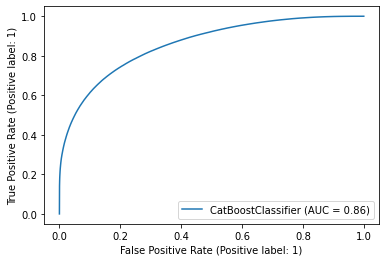

In [58]:
plot_roc_curve(model_catboost, x_train, y_train)

# Probabilities

In [59]:
# Make predictions with probabilities
y_probs = model_catboost.predict_proba(x_test)

y_probs[:5], len(y_probs)

(array([[0.2548732 , 0.7451268 ],
        [0.7348484 , 0.2651516 ],
        [0.106844  , 0.893156  ],
        [0.15043965, 0.84956035],
        [0.73511749, 0.26488251]]),
 500000)

In [60]:
y_probs_positive = y_probs[:, 1] # all lines 2nd column, 1 - value
y_probs_positive[:10]

array([0.7451268 , 0.2651516 , 0.893156  , 0.84956035, 0.26488251,
       0.24028784, 0.03495599, 0.38323115, 0.96404554, 0.81196763])

# Output

In [61]:
y_probs_positive.shape

(500000,)

In [62]:
df_sample = pd.read_csv("data/TabularPlaygroundSeries-Oct2021/sample_submission.csv")

In [63]:
df_sample.shape

(500000, 2)

In [64]:
df_sample.columns

Index(['id', 'target'], dtype='object')

In [65]:
df_sample["target"] = y_probs_positive

In [66]:
df_sample.to_csv("E:\downloads\sample_submission.csv", index=False)